# data reading

In [1]:
%reload_ext autoreload
%autoreload 2

from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm

In [2]:
df_train = read_data('data/train', 'training')
df_test = read_data('data/test', 'test')

# data exploration

In [3]:
df_train['label_text'] = df_train['label'].map({0: "non-harmful",
                                                1: "cyberbullying",
                                                2: "hate-speech"})

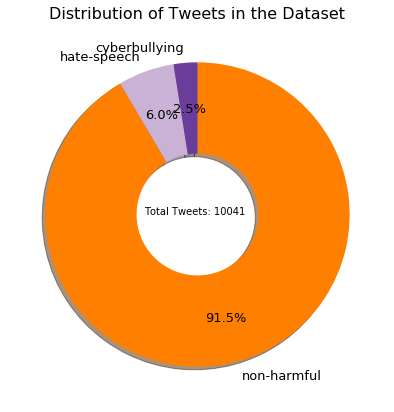

In [5]:
plt.figure(figsize = (7,7))
sorted_counts = df_train['label_text'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 13}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df_train.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16);
plt.savefig("docs/training_data.png")

right from the beginning we can that the imbalanced nature of the dataset will cause problems. Some remedies could include down-sampling or over-sampling the dataset but to ensure simplicity, we will try to use a weighted cross entropy loss first.

### create validation set for model validation during training

In [22]:
X_train, y_train = df_train[['text']], df_train[['label']]
X_test, y_test = df_test[['text']], df_test[['label']]

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                 y_train, 
                                                 random_state=42)

print('Number of rows in the total set: {}'.format(df_train.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 10041
Number of rows in the training set: 7530
Number of rows in the test set: 1000


# data cleaning

Data cleaning consisted of removing uncessary 

In [24]:
def clean_tweet(tweet):
    """
    Function that cleans a single tweet
    Seperate function from SentenceCleaner class to be able to test different methods easily in the notebook
    """
    entry = SentenceCleaner(tweet)
    entry.html_tag()
    entry.urls()
    entry.handle()
    entry.hashtag()
    entry.tolowercase()
    entry.emojis()
    return entry.sentence


In [25]:
X_train = X_train['text'].apply(clean_tweet)
X_val = X_val['text'].apply(clean_tweet)
X_test = X_test['text'].apply(clean_tweet)

# pre-trained Polish Roberta embeddings
I decided to use pre-trained embeddings from Polish Roberta (base -- to keep the model small for docker deployment) which was trained on similar data related to online cyber bullying. 

* Polish Roberta (just like BERT) transforms a word into a vector of size $1 \times 768 $
* Hence, with a plan in sight to use this model as a feature extractor (encoder) for a simple text classification CNN, we need to set a steady sequnce size. In this case I took the max length of the train dataset.
* Prior to padding, the words are tokenized. Neccessary functions can be found in [polishbert.py].


In [15]:
from polishbert import *
embeddings, tokenizer = load_embeddings(model_dir = "roberta_base_transformers")

In [16]:
torch.__version__

'1.4.0'

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:
max_seq = X_train.map(lambda x: len(x.split(" "))).max()
max_seq

30

In [ ]:
%time
train_indices = tokenize_and_pad_text(X_train, max_seq, tokenizer).to(device)
val_indices = tokenize_and_pad_text(X_val, max_seq, tokenizer).to(device)
test_indices = tokenize_and_pad_text(X_test, max_seq, tokenizer).to(device)

In [ ]:
embeddings = embeddings.to(device)

#### extract in batches due to the sheer size of the vector which can't fit in gpu memory and will take ages on the cpu



In [ ]:
%%time

X_train = extract_in_batches(train_indices, embeddings, batch_size=30)
print("train")
X_val = extract_in_batches(val_indices, embeddings, batch_size=30)
print("val")
X_test = extract_in_batches(test_indices, embeddings, batch_size=30)
print("test")

In [ ]:
del embeddings

In [ ]:
torch.cuda.empty_cache()

In [ ]:
y_train = targets_to_tensor(y_train,'label')#.to(device, dtype=torch.float32)
y_val = targets_to_tensor(y_val,'label')#.to(device, dtype=torch.float32)
y_test = targets_to_tensor(y_test,'label')#.to(device, dtype=torch.float32)

In [ ]:
torch.save(X_train, 'data/X_train.pt')
torch.save(y_train, 'data/y_train.pt')
torch.save(X_test, 'data/X_test.pt')
torch.save(X_val, 'data/X_val.pt')
torch.save(y_val, 'data/y_val.pt')
torch.save(y_test, 'data/y_test.pt')

# load

In [1]:
import torch

In [2]:
X_train = torch.load('data/X_train.pt')
y_train = torch.load('data/y_train.pt')
X_val = torch.load('data/X_val.pt')
y_val = torch.load('data/y_val.pt')
X_test = torch.load('data/X_test.pt')
y_test = torch.load('data/y_test.pt')

In [4]:
#reproducability (seed 42 gave poor results :P)
torch.manual_seed(2020)

# now for sentence classification we will use KimCNN
* Convolutional Neural Networks for Sentence Classification https://arxiv.org/pdf/1408.5882.pdf
* KimCNN is a simple yet very effective network for classifying text. 
    * it takes a word embedding as input. Applues convolutions of different sizes to model words of different sizes. Then it applies Relu, applying 1 max pooling to downsample everything . Concatenates these vetors. Adds dropout to avoid overfitting. And at the end we apply softmax.

In [5]:
%reload_ext autoreload
%autoreload 2

from model import *

from time import time
import torch.utils.data as data_utils
import numpy as np

### defining model

In [8]:
#hyperparameters -- model
embed_num = X_train.shape[1]
embed_dim = X_train.shape[2]
class_num = len(y_train.unique())
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.3
static = True

#model
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

#### necessary re-weighting of classes due to the imbalanced nature of the dataset

In [13]:
_, sums = y_train.unique(return_counts=True)
sums = np.array(sums)
weights=torch.Tensor(max(sums)/sums)

### Cross entropy loss was chosen due to the task being a multi-class classification one

In [14]:
#hyperparameters -- training
n_epochs = 20
batch_size = 10
lr = 0.001
#optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)
loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(weights))

### defining data loaders

In [16]:
train_data = data_utils.TensorDataset(X_train, y_train)
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = data_utils.TensorDataset(X_val, y_val)
val_loader = data_utils.DataLoader(val_data, batch_size=batch_size)


### main training loop

In [17]:
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    start_time = time()
    train_loss = 0    
    model.train(True)
    
    for batch, (x_batch, y_batch) in enumerate(train_loader):
        #x_batch = x_batch.to(device)
        #y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        optimizer.zero_grad()
        #print(y_pred)
        loss = loss_fn(y_pred, y_batch.to(dtype=torch.long))
        #loss = loss_fn(y_pred, dtype=torch.long))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= batch
    
    train_losses.append(train_loss)
    elapsed = time() - start_time
    model.eval() # disable dropout for deterministic output
    # deactivate autograd engine to reduce memory usage and speed up computations
    
    with torch.no_grad(): 
        val_loss, batch = 0, 1
        for batch, (x_batch, y_batch) in enumerate(val_loader):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch.to(dtype=torch.long))
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)    
    print(
    "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
    % (epoch + 1, train_losses[-1], val_losses[-1], elapsed))

Epoch 1 Train loss: 0.96. Validation loss: 0.89. Elapsed time: 9.63s.
Epoch 2 Train loss: 0.90. Validation loss: 0.87. Elapsed time: 8.86s.
Epoch 3 Train loss: 0.86. Validation loss: 0.86. Elapsed time: 8.75s.
Epoch 4 Train loss: 0.85. Validation loss: 0.85. Elapsed time: 8.74s.
Epoch 5 Train loss: 0.84. Validation loss: 0.87. Elapsed time: 9.41s.
Epoch 6 Train loss: 0.83. Validation loss: 0.85. Elapsed time: 9.77s.


KeyboardInterrupt: 

training and validation curves would diverge quickly so I stopped the training here. For a more robust training **proper early stopping** needs to be implemented ** to avoid overfitting

In [18]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Losses')

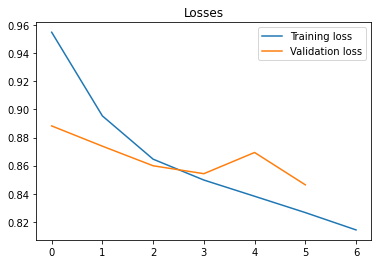

In [19]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

## Model evaluation on the test set

In [20]:
model.eval() 
y_preds = []
batch = 0
for x_batch, y_batch, batch in generate_batch_data(X_test, y_test, batch_size):
    y_pred = model(x_batch)
    y_pred = torch.argmax(y_pred, dim=1)
    y_preds.extend(y_pred.detach().numpy().tolist())
y_preds_np = np.array(y_preds)

In [21]:
np.unique(np.array(y_test), return_counts=True)

(array([0., 1., 2.], dtype=float32), array([866,  25, 109]))

In [22]:
np.unique(y_preds_np, return_counts=True)

(array([0, 1, 2]), array([909,   2,  89]))

#### so the network predicts every instance there is present in the dataset but struggles heavily with differentiating harmful speech from outright cyber-bullying

In [23]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

In [24]:
# F1-score (micro and macro is used for evaulation in order )

array([0, 1, 2])

In [25]:
f1_score(np.array(y_test), y_preds_np, average='macro')

0.5298588387790265

In [26]:
f1_score(np.array(y_test), y_preds_np, average='micro')

0.891

In [27]:
torch.save(model.state_dict(), 'models/emb_roberta_kimcnn.pth')

# Conclusion
* I have trained a simple CNN with Polish Roberta embeddings to identify hate speech. The imbalanced nature of the dataset proved tricky to deal with even when playing around with the dropout rate to prevent overfitting.
* We achieve an F1 macro score of 52.99 \% and an F1 micro score of 89.1 \% which puts this model above the best model that took part at the competition